# Linear Regression with Statsmodels and Scikit-Learn

There are many ways to fit a linear regression and in python I find myself commonly using both
[scikit-learn](http://scikit-learn.org/stable/modules/linear_model.html) and [statsmodels](http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html). This notebook demos some common tasks using these libraries:
* Linear regressions in both
* Using [dummy variables](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
* Multilinear regression
* Quadratic and polynomial regressions
* Exponential regressions

You can also create [polynomial fits with numpy](http://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) and more [general curve fits with scipy](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

To get started let's load in the libraries that we'll need.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn import linear_model

For the first few examples we'll use the famous [Iris dataset](http://archive.ics.uci.edu/ml/datasets/Iris). Seaborn provides a few data sets including this one. Let's load the data and take a quick look using [Seaborn's pairplot](https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.pairplot.html).

In [2]:
# Load the data into a pandas dataframe
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


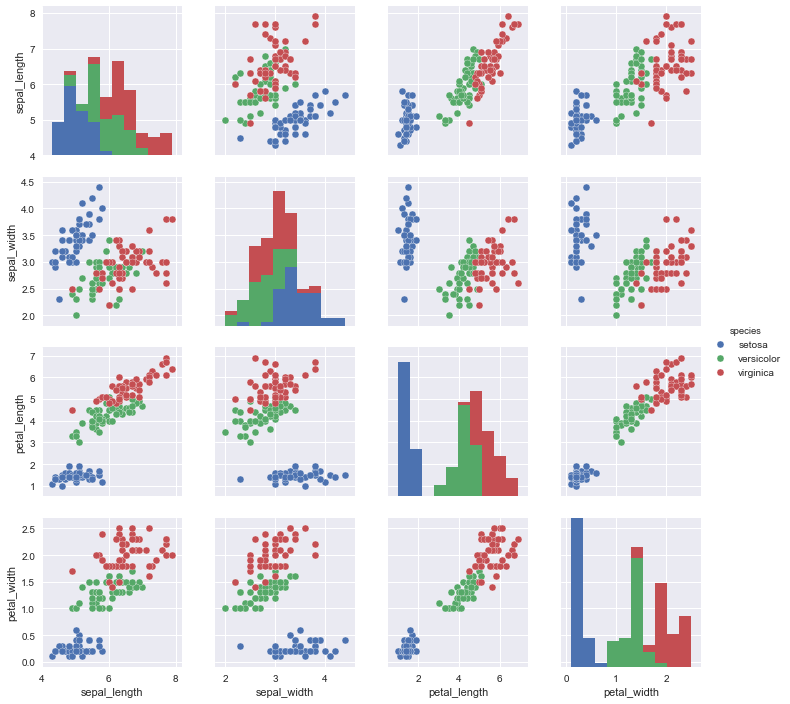

In [3]:
# Quick plot of the data using seaborn
sns.pairplot(iris, hue="species")
sns.plt.show()

You can see a pretty strong linear relationship between `petal_length` and `petal_width`. Let's fit a linear regression. Seaborn can [plot the data with a regression line](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html) so let's do that first (but it doesn't give us much in the way of statistics).

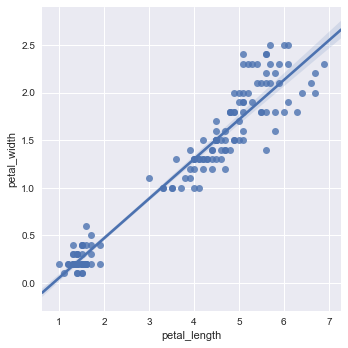

In [4]:
sns.lmplot(x="petal_length", y="petal_width", data=iris)
sns.plt.show()

Now let's use scikit-learn to find the best fit line.

In [5]:
# from sklearn import linear_model

X = iris[["petal_length"]]
y = iris["petal_width"]

# Fit the linear model
model = linear_model.LinearRegression()
results = model.fit(X, y)

# Print the coefficients
print results.intercept_, results.coef_

-0.363075521319 [ 0.41575542]


This means that our best fit line is:
$$y = a + b x$$
where $a = -0.363075521319$ and $b = 0.41575542$.

Next let's use `statsmodels`.

In [6]:
# import statsmodels.api as sm

# Note the swap of X and y
model = sm.OLS(y, X)
results = model.fit()
# Statsmodels gives R-like statistical output
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            petal_width   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     4417.
Date:                Fri, 21 Apr 2017   Prob (F-statistic):          1.22e-112
Time:                        14:58:44   Log-Likelihood:                -8.7179
No. Observations:                 150   AIC:                             19.44
Df Residuals:                     149   BIC:                             22.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
petal_length     0.3365      0.005     66.463   

If you look closely you'll note that this model doesn't include an intercept by default like scikit-learn does. There's an easy way to do this using numpy's [Vandermonde matrix function](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.vander.html) `numpy.vander`.

In [7]:
X = [1, 2, 3]
np.vander(X, 3)

array([[1, 1, 1],
       [4, 2, 1],
       [9, 3, 1]])

As you can see, `np.vander` gives us the powers of the input matrix or array. We can use it to simply add a constant row for the intercept (zeroth power) or to do polynomial fits (larger exponents). First let's redo the statsmodels fit with an intercept.

In [8]:
X = iris["petal_length"]
X = np.vander(X, 2) # add a constant row for the intercept
y = iris["petal_width"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            petal_width   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     1882.
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           4.68e-86
Time:                        14:58:44   Log-Likelihood:                 24.796
No. Observations:                 150   AIC:                            -45.59
Df Residuals:                     148   BIC:                            -39.57
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.4158      0.010     43.387      0.0

Note that the coefficients are almost identical to what we saw before with scikit-learn, and the fit is pretty good ($R^2=0.927$). Let's see if adding in the species helps. Since that feature is categorical, we need to use dummy variables.

In [9]:
dummies = pd.get_dummies(iris["species"])
# Add to the original dataframe
iris = pd.concat([iris, dummies], axis=1)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,setosa,1,0,0
1,4.9,3.0,1.4,0.2,setosa,1,0,0
2,4.7,3.2,1.3,0.2,setosa,1,0,0
3,4.6,3.1,1.5,0.2,setosa,1,0,0
4,5.0,3.6,1.4,0.2,setosa,1,0,0


Now we perform a multilinear regression with the dummy variables added.

In [10]:
X = iris[["petal_length", "setosa", "versicolor", "virginica"]]
X = sm.add_constant(X) # another way to add a constant row for an intercept
y = iris["petal_width"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            petal_width   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     845.5
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           4.88e-92
Time:                        14:58:44   Log-Likelihood:                 46.704
No. Observations:                 150   AIC:                            -85.41
Df Residuals:                     146   BIC:                            -73.37
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.2501      0.098      2.561   

In this case it looks like we got a slight improvement from including the dummy variables. The dummy variables have a bigger impact on a fit between `petal_length` and `sepal_length`.

In [11]:
X = iris[["petal_length"]]
X = sm.add_constant(X)
y = iris["sepal_length"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           sepal_length   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     468.6
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           1.04e-47
Time:                        14:58:44   Log-Likelihood:                -77.020
No. Observations:                 150   AIC:                             158.0
Df Residuals:                     148   BIC:                             164.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            4.3066      0.078     54.939   

In [20]:
X = iris[["petal_length", "setosa", "versicolor", "virginica"]]
y = iris["sepal_length"]

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           sepal_length   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     249.4
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           3.10e-57
Time:                        14:58:59   Log-Likelihood:                -48.116
No. Observations:                 150   AIC:                             104.2
Df Residuals:                     146   BIC:                             116.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
petal_length     0.9046      0.065     13.962      0.000         0.777     1.033
setosa           3.6835      0.106     34.719      0.000         3.474     3.893
versicolor       2.0826      0.280      7.435      0.000         1.529     2.636
virginica        1.5659      0.363      4.315      0.000         0.849     2.283
==============================================================================
Omnibus:                        0.578   Durbin-Watson:                   1.802
Prob(Omnibus):                  0.749   Jarque-Bera (JB):                0.672
Skew:                           0.140   Prob(JB):                        0.715
Kurtosis:                       2.830   Cond. No.                         71.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Quadratic Fit

Next we look at a data set that needs a quadratic fit. Let's do both a linear and quadratic fit and compare.

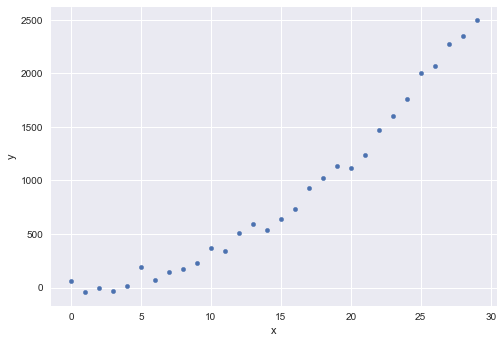

In [13]:
func = lambda x: 2 + 0.5 * x + 3 * x ** 2 + 5 * stats.norm.rvs(0, 10)
df = pd.DataFrame()
df["x"] = list(range(0, 30))
df["y"] = map(func, df["x"])
df.plot.scatter(x='x', y='y')

In [14]:
# Linear Fit
X = df["x"]
X = np.vander(X, 2) # add a constant row for the intercept
y = df["y"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     374.8
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           9.51e-18
Time:                        14:58:44   Log-Likelihood:                -202.74
No. Observations:                  30   AIC:                             409.5
Df Residuals:                      28   BIC:                             412.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            88.0534      4.548     19.360      0.0

In [15]:
# Quadratic Fit
X2 = df['x']
X2 = np.vander(X2, 3) # add a constant and quadratic term
y = df["y"]

model2 = sm.OLS(y, X2)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     2670.
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           9.38e-32
Time:                        14:58:44   Log-Likelihood:                -163.35
No. Observations:                  30   AIC:                             332.7
Df Residuals:                      27   BIC:                             336.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             2.9992      0.161     18.603      0.0

We see that the quadratic fit is better. We can plot the residuals in both cases to see how far off the models are in each case.

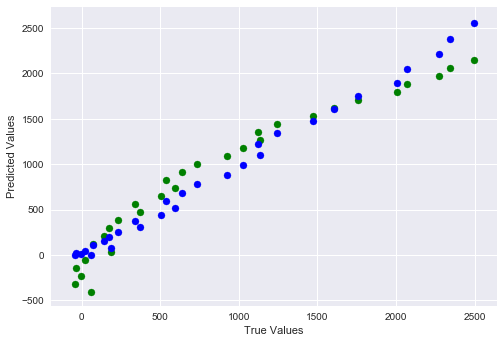

In [16]:
# Plot true values versus the predictions
plt.scatter(df['y'], results.predict(), color="g", label="Linear")
plt.scatter(df['y'], results2.predict(), color="b", label="Quadratic")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.show()

Although it's a little hard to tell from the plot (since both fits are good), the blue (quadratic) fit is closer to "y=x", indicating a closer agreement with the true values and the model's predictions.

Higher order polynomial regressions are as easy as increasing the exponent parameter in `numpy.vander`.

# Exponential functions

We can also transform our data before applying linear regression. This allows us to fit functions such as exponentials of the form $y=A e^{k x}$ using linear regression. Here's some exponentially distributed data.

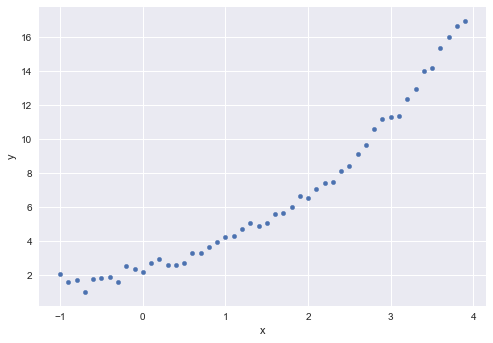

In [17]:
func = lambda x: 2.5 * np.exp(0.5 * x) + stats.norm.rvs(0, 0.3)
df = pd.DataFrame()
df["x"] = np.arange(-1, 4, 0.1)
df["y"] = map(func, df["x"])
df.plot.scatter(x='x', y='y')

If we take the log of the `y`-variable we get something more linear.

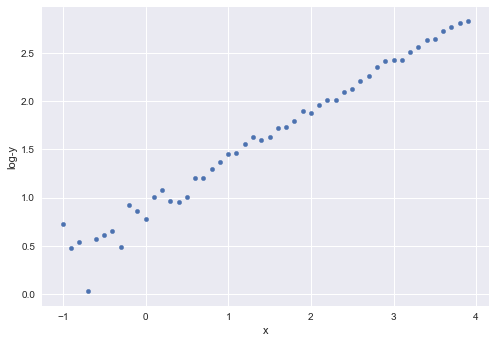

In [18]:
df["log-y"] = np.log(df["y"])
df.plot.scatter(x='x', y='log-y')

We can then use linear regression to determine $k$ and $\log A$, since taking the $\log$ of both sides of $y = A e^{k x}$ gives us $\log y = \log A + k x$.

In [19]:
X = df["x"]
X = sm.add_constant(X)
y = df["log-y"]

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  log-y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     2330.
Date:                Fri, 21 Apr 2017   Prob (F-statistic):           2.41e-42
Time:                        14:58:45   Log-Likelihood:                 41.138
No. Observations:                  50   AIC:                            -78.28
Df Residuals:                      48   BIC:                            -74.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8746      0.022     40.217      0.0

As you can see the fit is very good.